In [1]:
import torch
from qiskit_machine_learning.utils import algorithm_globals
from scipy.stats import multivariate_normal, entropy
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import cm
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import SamplerQNN
from torch import nn
from torch.optim import Adam
import time 

In [2]:
algorithm_globals.random_seed = 123
torch.manual_seed(123)

In [3]:
dim = 2
n_values = 2**3
n_qubits = dim * int(np.log2(n_values))
print("Dimension : ", dim)
print("Number of total values : ", n_values)
print("Number of qubits : ", n_qubits)

Dimension :  2
Number of total values :  8
Number of qubits :  6


The data is sampled from a two-dimensional normal distribution. Since these values are continuos, we evaluate the distribution of the square grid $\Omega ^2$, where $\Omega = (-2,2)$, with a discretization of $8$, for a total of $64$ points.

In [4]:
interval = np.linspace(-2, 2, n_values)
coords = interval
covariance_matrix = np.array([[1,0], [0,1]])                    # we suppose that the 2 variables are indipendent of one another 
print(covariance_matrix.shape)
continuos_data = multivariate_normal(mean = [0,0], cov = covariance_matrix, seed = algorithm_globals.random_seed )

(2, 2)


In [5]:
tiled_interval = np.tile(interval, reps = len(interval))
repeated_interval = np.repeat(interval, len(interval))
grid_elements = np.transpose([np.tile(coords, len(coords)), np.repeat(coords, len(coords))])
print(grid_elements)
grid_data = continuos_data.pdf(grid_elements)                       # evaluate the grid elements using the pdf 
grid_data = grid_data/np.sum(grid_data)

[[-2.         -2.        ]
 [-1.42857143 -2.        ]
 [-0.85714286 -2.        ]
 [-0.28571429 -2.        ]
 [ 0.28571429 -2.        ]
 [ 0.85714286 -2.        ]
 [ 1.42857143 -2.        ]
 [ 2.         -2.        ]
 [-2.         -1.42857143]
 [-1.42857143 -1.42857143]
 [-0.85714286 -1.42857143]
 [-0.28571429 -1.42857143]
 [ 0.28571429 -1.42857143]
 [ 0.85714286 -1.42857143]
 [ 1.42857143 -1.42857143]
 [ 2.         -1.42857143]
 [-2.         -0.85714286]
 [-1.42857143 -0.85714286]
 [-0.85714286 -0.85714286]
 [-0.28571429 -0.85714286]
 [ 0.28571429 -0.85714286]
 [ 0.85714286 -0.85714286]
 [ 1.42857143 -0.85714286]
 [ 2.         -0.85714286]
 [-2.         -0.28571429]
 [-1.42857143 -0.28571429]
 [-0.85714286 -0.28571429]
 [-0.28571429 -0.28571429]
 [ 0.28571429 -0.28571429]
 [ 0.85714286 -0.28571429]
 [ 1.42857143 -0.28571429]
 [ 2.         -0.28571429]
 [-2.          0.28571429]
 [-1.42857143  0.28571429]
 [-0.85714286  0.28571429]
 [-0.28571429  0.28571429]
 [ 0.28571429  0.28571429]
 

In [6]:
print(grid_data)

[0.00099208 0.00264229 0.00507693 0.00703739 0.00703739 0.00507693
 0.00264229 0.00099208 0.00264229 0.00703739 0.01352173 0.01874316
 0.01874316 0.01352173 0.00703739 0.00264229 0.00507693 0.01352173
 0.02598084 0.03601337 0.03601337 0.02598084 0.01352173 0.00507693
 0.00703739 0.01874316 0.03601337 0.04991995 0.04991995 0.03601337
 0.01874316 0.00703739 0.00703739 0.01874316 0.03601337 0.04991995
 0.04991995 0.03601337 0.01874316 0.00703739 0.00507693 0.01352173
 0.02598084 0.03601337 0.03601337 0.02598084 0.01352173 0.00507693
 0.00264229 0.00703739 0.01352173 0.01874316 0.01874316 0.01352173
 0.00703739 0.00264229 0.00099208 0.00264229 0.00507693 0.00703739
 0.00703739 0.00507693 0.00264229 0.00099208]


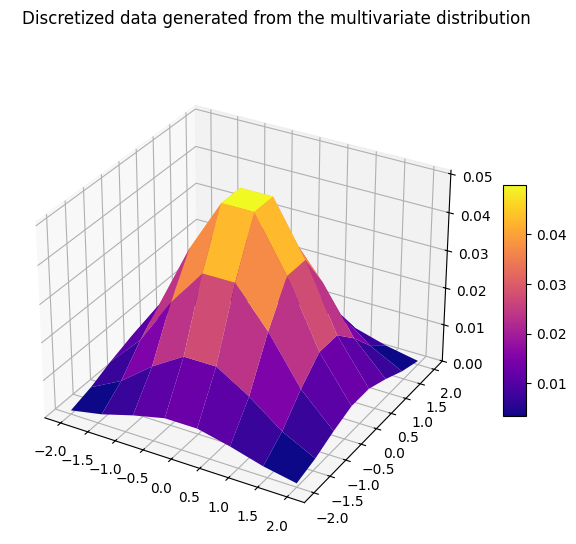

In [7]:
# create grid to plot the surface 
X, Y = np.meshgrid(interval, interval)

grid_shape = (n_values, n_values)
grid_data = np.reshape(grid_data, newshape = grid_shape)
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={"projection": "3d"})
fig.suptitle(r'Discretized data generated from the multivariate distribution')
surface = ax.plot_surface(X, Y, grid_data, cmap = cm.plasma)
fig.colorbar(surface, shrink = 0.5, aspect = 10 )


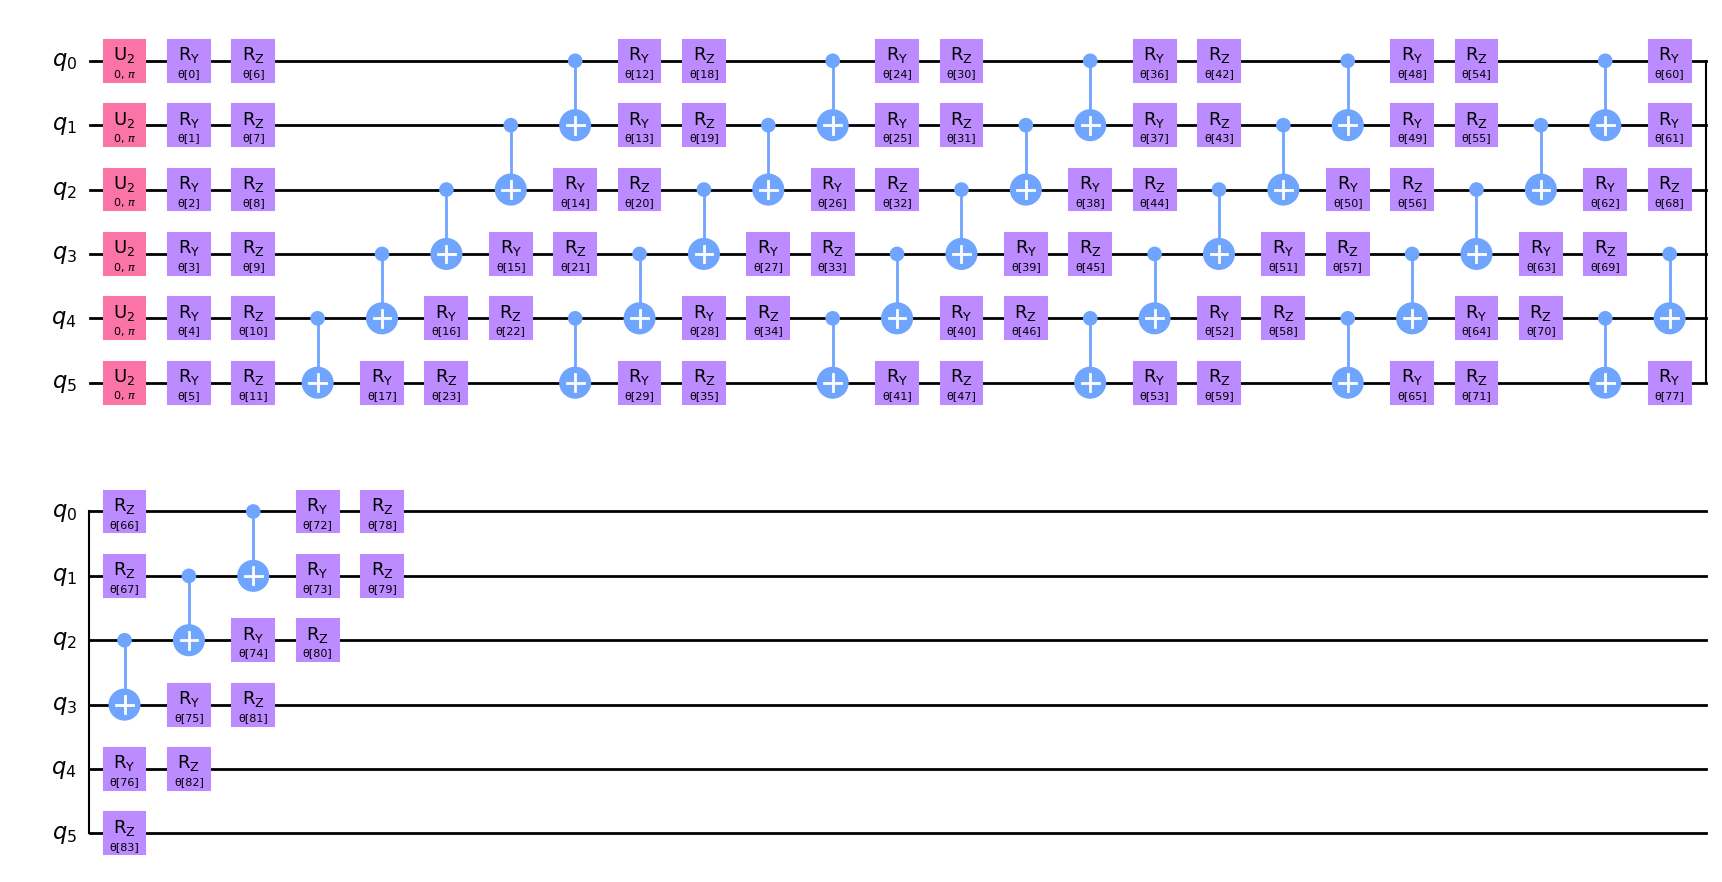

In [8]:
qc = QuantumCircuit(n_qubits)

for q in qc.qubits:
    qc.h(q)

qc.draw(output = "mpl", style = "clifford")

ansatz = EfficientSU2(num_qubits = n_qubits, reps = 6)
qc.compose(ansatz, inplace = True)
qc.decompose().draw(output = "mpl", style = "clifford")

In [9]:
print("Number of parameters : ", qc.num_parameters)

Number of parameters :  84


In [10]:
sampler = Sampler()

# define a function that creates a generator compatible with Py-Torch
def create_generator() -> TorchConnector:
    qnn = SamplerQNN(
        circuit = qc,
        sampler = sampler,
        input_params = [],
        weight_params = qc.parameters,
        sparse = False
    )

    # initialise the initial weights randomly 
    initial_weights = algorithm_globals.random.random(qc.num_parameters)

    return TorchConnector(qnn, initial_weights)

# we can also define a Py-Torch classical neural network that represents the discriminator 

class classical_discriminator(nn.Module):
    def __init__(self, input_size):
        super(classical_discriminator, self).__init__()

        # define the input of the neural network
        self.linear_input = nn.Linear(input_size, 20)                                   # linear input layer 
        self.leaky_relu = nn.LeakyReLU(0.2)                                             # takes as input the negative slope of the ReLU function 
        self.linear20 = nn.Linear(20, 1)                                                # linear hidden layers 
        self.sigmoid = nn.Sigmoid()                                                     # sigmoid output layer


    # define a fowrard method for the network

    def forward(self, input:torch.Tensor) -> torch.Tensor:

        # apply a forward pass for each layer in the neural network
        x = self.linear_input(input)
        x = self.leaky_relu(x)
        x = self.linear20(x)
        x = self.sigmoid(x)
        
        return x 

In [11]:
generator = create_generator()
discriminator = classical_discriminator(dim)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


As the loss function we can choose the binary cross entropy 
$$
\mathcal{L}(\vec{\theta})= \sum_{j}p_j(\vec{\theta}) \left( y_j\log x_j + (1-y_j)\log(1-x_j)\right)
$$

Since the function is not differentiable with respect to the weights we can implement it manually. We employ an optimization procedure based on the optimizer Adam.

In [12]:
def loss_function(input, target, weight):
    """
    Defines the binary cross entropy (BCE) manually in order to compute gradient with respect to the weights.
    Inputs:
    input = corresponds to the data value x_j
    weight = corresponds to the weitgh
    target = corresponds to the target value y_j
    """
    bce = target * torch.log(input) + (1-target) * torch.log(1 - input)
    weighted_bce = weight*bce
    loss = -torch.sum(weighted_bce)
    return loss

learning_rate  = 0.01
# first and second momentum parameters
beta1 = 0.7                                                 # values from reference [1]                                 
beta2 = 0.999

generator_optimizer = Adam(generator.parameters(), lr = learning_rate, betas = (beta1, beta2), weight_decay = 0.005)
discriminator_optimizer = Adam(params = discriminator.parameters(), lr = learning_rate, betas = (beta1, beta2), weight_decay = 0.005)

In [13]:
print("Discretized data on the grid : ")
print(grid_data)
real_distribution = torch.tensor(data = grid_data, dtype = torch.float)         # converts data into a tensor torch variable 
print("Torch disribution : ")
print(real_distribution)

Discretized data on the grid : 
[[0.00099208 0.00264229 0.00507693 0.00703739 0.00703739 0.00507693
  0.00264229 0.00099208]
 [0.00264229 0.00703739 0.01352173 0.01874316 0.01874316 0.01352173
  0.00703739 0.00264229]
 [0.00507693 0.01352173 0.02598084 0.03601337 0.03601337 0.02598084
  0.01352173 0.00507693]
 [0.00703739 0.01874316 0.03601337 0.04991995 0.04991995 0.03601337
  0.01874316 0.00703739]
 [0.00703739 0.01874316 0.03601337 0.04991995 0.04991995 0.03601337
  0.01874316 0.00703739]
 [0.00507693 0.01352173 0.02598084 0.03601337 0.03601337 0.02598084
  0.01352173 0.00507693]
 [0.00264229 0.00703739 0.01352173 0.01874316 0.01874316 0.01352173
  0.00703739 0.00264229]
 [0.00099208 0.00264229 0.00507693 0.00703739 0.00703739 0.00507693
  0.00264229 0.00099208]]
Torch disribution : 
tensor([[0.0010, 0.0026, 0.0051, 0.0070, 0.0070, 0.0051, 0.0026, 0.0010],
        [0.0026, 0.0070, 0.0135, 0.0187, 0.0187, 0.0135, 0.0070, 0.0026],
        [0.0051, 0.0135, 0.0260, 0.0360, 0.0360, 0.026

In [14]:
real_distribution = real_distribution.reshape(-1,1)                             # reshap data in the same form of valid data and fake data 
print("Reshaped distribution : ")
print(real_distribution)

Reshaped distribution : 
tensor([[0.0010],
        [0.0026],
        [0.0051],
        [0.0070],
        [0.0070],
        [0.0051],
        [0.0026],
        [0.0010],
        [0.0026],
        [0.0070],
        [0.0135],
        [0.0187],
        [0.0187],
        [0.0135],
        [0.0070],
        [0.0026],
        [0.0051],
        [0.0135],
        [0.0260],
        [0.0360],
        [0.0360],
        [0.0260],
        [0.0135],
        [0.0051],
        [0.0070],
        [0.0187],
        [0.0360],
        [0.0499],
        [0.0499],
        [0.0360],
        [0.0187],
        [0.0070],
        [0.0070],
        [0.0187],
        [0.0360],
        [0.0499],
        [0.0499],
        [0.0360],
        [0.0187],
        [0.0070],
        [0.0051],
        [0.0135],
        [0.0260],
        [0.0360],
        [0.0360],
        [0.0260],
        [0.0135],
        [0.0051],
        [0.0026],
        [0.0070],
        [0.0135],
        [0.0187],
        [0.0187],
        [0.0135],
   

In [15]:
# we can now plot the result of training 

epochs = 50                                             # number of epochs 
n_outputs_qnn = n_values**dim

# list to store the values during training
discriminator_loss = []
generator_loss = []
start = time.time()
for epoch in range(epochs):
    
    valid_data = torch.ones(n_outputs_qnn, 1, dtype = torch.float)
    fake_data = torch.zeros(n_outputs_qnn, 1, dtype = torch.float)

    # input 

    real_distribution = torch.tensor(data = grid_data, dtype = torch.float).reshape(-1,1)

    # samples 
    
    samples = torch.tensor(grid_elements, dtype = torch.float)
    discriminator_values = discriminator(samples)

    # generate data 
    
    generator_distribution  = generator(torch.tensor([])).reshape(-1,1)

    # train generator 
    discriminator_optimizer.zero_grad()
    generator_loss_value = loss_function(discriminator_values, valid_data, generator_distribution)
    generator_loss.append(generator_loss_value.detach().item())

    generator_loss_value.backward(retain_graph = True)
    generator_optimizer.step()

    # train discriminator 
    discriminator_optimizer.zero_grad()

    real_loss = loss_function(discriminator_values, valid_data, real_distribution)
    fake_loss = loss_function(discriminator_values, fake_data, generator_distribution.detach())
    discriminator_loss_value = (real_loss + fake_loss) / 2
    discriminator_loss.append(discriminator_loss_value.detach().item())

    discriminator_optimizer.step()
    #discriminator_loss_value.backward()

elapsed_time = time.time()-start    

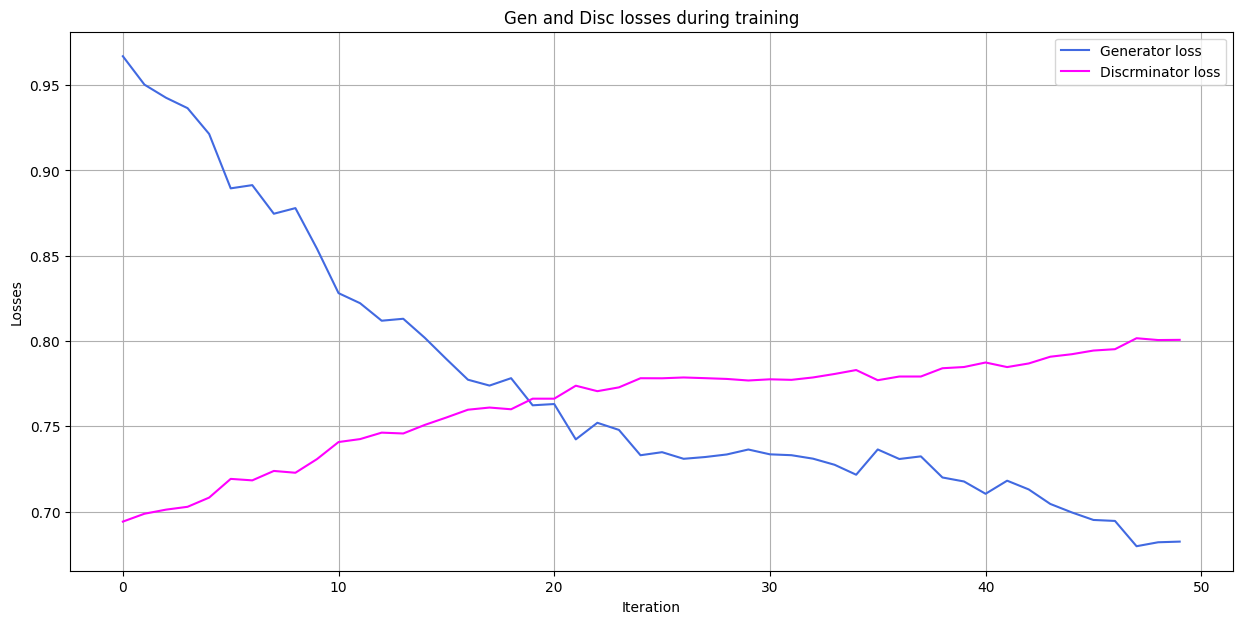

In [16]:
# plot the results at the end of training
plt.figure(figsize = [15,7])
plt.title(r'Gen and Disc losses during training')
plt.plot(generator_loss, c = 'royalblue', label = 'Generator loss')
plt.plot(discriminator_loss, c = 'fuchsia', label = 'Discrminator loss')
plt.ylabel(r'Losses')
plt.xlabel(r'Iteration')
plt.legend(loc = 'best')
plt.grid()


In [17]:
print("Total training time : ")
print(f"{elapsed_time: 0.2f} sec")

Total training time : 
 60.26 sec


# References 
[1] Diederik P. Kingma, Jimmy Ba, " Adam: A Method for Stochastic Optimization". Arxiv : https://arxiv.org/abs/1412.6980